In [ ]:
# 1. Import Library
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.mixture import GaussianMixture
import xgboost as xgb
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


In [ ]:
# 2. Load Dataset
df = pd.read_csv('/content/gene_exp_data.csv')
df = df.transpose()
df.columns = df.iloc[0]
df = df[1:]

# Labels
labels = ['apocrine']*6 + ['basal']*16 + ['luminal']*27
df['label'] = labels

# Split X dan y
X_raw = df.drop('label', axis=1)
y = df['label']

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y,
                                                    test_size=0.5,
                                                    stratify=y,
                                                    random_state=77)


In [ ]:
# 3. Define Models
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=77),
    "Random Forest": RandomForestClassifier(random_state=77),
    "SVM (Linear)": SVC(kernel='linear', probability=True, random_state=77),
    "Logistic Regression": LogisticRegression(max_iter=10000, random_state=77),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB(),
    "Lasso Logistic Regression": LogisticRegression(penalty='l1', solver='saga', max_iter=10000, random_state=77)
}


In [ ]:
# 4. Train-Evaluate-CV-Plot
cv_results = {}
roc_curves = {}

# Cross-Validation Setting
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=77)

for name, model in models.items():
    print(f"\n=== {name} ===")

    # Fit model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:\n", cm)

    # Classification Report
    cr = classification_report(y_test, y_pred)
    print("\nClassification Report:\n", cr)

    # Top 10 Important Features (if applicable)
    if hasattr(model, 'feature_importances_'):
        print("\nTop 10 Important Features (Feature Importances):")
        feat_importances = pd.Series(model.feature_importances_, index=X_raw.columns)
        print(feat_importances.sort_values(ascending=False)[:10])
    elif hasattr(model, 'coef_'):
        print("\nTop 10 Important Features (Coefficients):")
        coeff = pd.Series(model.coef_[0], index=X_raw.columns)
        print(coeff.abs().sort_values(ascending=False)[:10])

    # Cross Validation Score
    scores = cross_val_score(model, X_scaled, y, cv=cv, scoring='accuracy')
    cv_results[name] = scores
    print(f"\nCross-Validation Accuracy: Mean = {scores.mean():.4f}, Std = {scores.std():.4f}")

    # ROC Curve (binarize labels)
    y_test_bin = label_binarize(y_test, classes=['apocrine', 'basal', 'luminal'])
    n_classes = y_test_bin.shape[1]

    if hasattr(model, "decision_function"):
        y_score = model.decision_function(X_test)
    else:
        y_score = model.predict_proba(X_test)

    roc_curves[name] = (y_test_bin, y_score)



=== Decision Tree ===

Confusion Matrix:
 [[ 1  1  1]
 [ 1  6  1]
 [ 1  0 13]]

Classification Report:
               precision    recall  f1-score   support

    apocrine       0.33      0.33      0.33         3
       basal       0.86      0.75      0.80         8
     luminal       0.87      0.93      0.90        14

    accuracy                           0.80        25
   macro avg       0.69      0.67      0.68        25
weighted avg       0.80      0.80      0.80        25


Top 10 Important Features (Feature Importances):
Unnamed: 0
209443_at      0.686445
209170_s_at    0.313555
202116_at      0.000000
205681_at      0.000000
206036_s_at    0.000000
205091_x_at    0.000000
212397_at      0.000000
203685_at      0.000000
201485_s_at    0.000000
201063_at      0.000000
dtype: float64

Cross-Validation Accuracy: Mean = 0.8578, Std = 0.1012

=== Random Forest ===

Confusion Matrix:
 [[ 3  0  0]
 [ 0  8  0]
 [ 0  0 14]]

Classification Report:
               precision    recall  f1

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Confusion Matrix:
 [[ 2  0  1]
 [ 0  8  0]
 [ 0  0 14]]

Classification Report:
               precision    recall  f1-score   support

    apocrine       1.00      0.67      0.80         3
       basal       1.00      1.00      1.00         8
     luminal       0.93      1.00      0.97        14

    accuracy                           0.96        25
   macro avg       0.98      0.89      0.92        25
weighted avg       0.96      0.96      0.96        25


Top 10 Important Features (Coefficients):
Unnamed: 0
208837_at      0.280851
201960_s_at    0.116187
205221_at      0.113744
202853_s_at    0.091227
211689_s_at    0.070282
213217_at      0.044494
220690_s_at    0.038636
202338_at      0.036010
209337_at      0.033229
211682_x_at    0.031054
dtype: float64

Cross-Validation Accuracy: Mean = 0.9800, Std = 0.0400


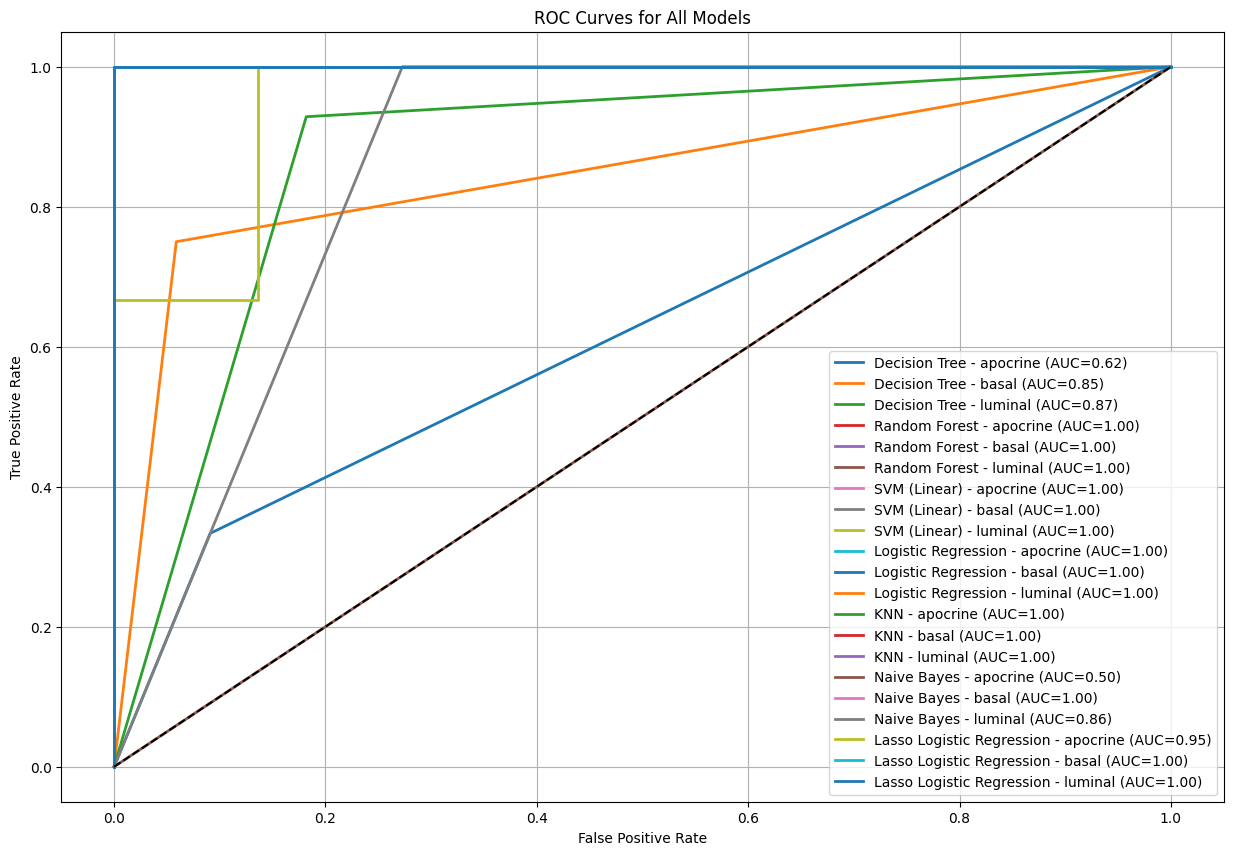

In [ ]:
# 5. Plot ROC Curves
plt.figure(figsize=(15,10))

for name, (y_test_bin, y_score) in roc_curves.items():
    for i in range(y_test_bin.shape[1]):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{name} - {y.unique()[i]} (AUC={roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


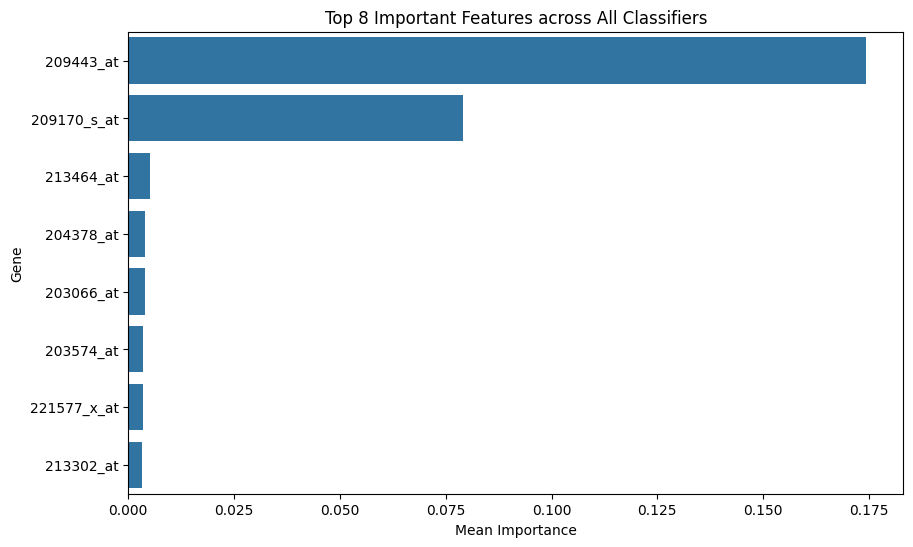

,0
Unnamed: 0,
209443_at,0.174378
209170_s_at,0.078971
213464_at,0.005108
204378_at,0.003943
203066_at,0.003932
203574_at,0.003537
221577_x_at,0.003464
213302_at,0.003357


In [ ]:
# Ambil feature importance dari semua model

# Feature importance Decision Tree
feat_importances_dt = pd.Series(dt_model.feature_importances_, index=X_raw.columns)

# Feature importance Random Forest
feat_importances_rf = pd.Series(rf_model.feature_importances_, index=X_raw.columns)

# Feature importance Logistic Regression (pakai absolut koefisien)
feat_importances_logreg = pd.Series(abs(logreg_model.coef_[0]), index=X_raw.columns)

# Feature importance SVM (pakai absolut koefisien)
feat_importances_svm = pd.Series(abs(svm_model.coef_[0]), index=X_raw.columns)

# Gabungkan jadi satu DataFrame
feat_all = pd.DataFrame({
    'Decision Tree': feat_importances_dt,
    'Random Forest': feat_importances_rf,
    'Logistic Regression': feat_importances_logreg,
    'SVM': feat_importances_svm
})

# Ambil 10 fitur paling sering penting
feat_mean = feat_all.mean(axis=1)
top_features = feat_mean.sort_values(ascending=False).head(8)

# Visualisasi
plt.figure(figsize=(10,6))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title('Top 8 Important Features across All Classifiers')
plt.xlabel('Mean Importance')
plt.ylabel('Gene')
plt.show()

top_features


In [ ]:
# Load Gene Annotation
anno = pd.read_csv('/content/final_annotation.csv')
anno.head()


,PROBEID,SYMBOL,ENTREZID,GENENAME,GO,EVIDENCE,ONTOLOGY,GOID,TERM
0,204667_at,FOXA1,3169,forkhead box A1,GO:0000122,IEA,BP,GO:0000122,negative regulation of transcription by RNA po...
1,204667_at,FOXA1,3169,forkhead box A1,GO:0000785,ISA,CC,GO:0000785,chromatin
2,204667_at,FOXA1,3169,forkhead box A1,GO:0000976,IDA,MF,GO:0000976,transcription cis-regulatory region binding
3,204667_at,FOXA1,3169,forkhead box A1,GO:0000978,IBA,MF,GO:0000978,RNA polymerase II cis-regulatory region sequen...
4,204667_at,FOXA1,3169,forkhead box A1,GO:0000978,IDA,MF,GO:0000978,RNA polymerase II cis-regulatory region sequen...
